In [260]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from tqdm import tqdm

In [261]:
DATA_DIR = 'data'

In [262]:
try:
    os.mkdir(os.path.join(DATA_DIR, 'preprocess'))
    os.mkdir(os.path.join(DATA_DIR, 'preprocess', 'training'))
    os.mkdir(os.path.join(DATA_DIR, 'preprocess', 'testing'))
except:
    pass

In [263]:
train_files = glob.glob(os.path.join(DATA_DIR, 'training', 'training', '*.png'))

In [264]:
def preprocess_image(filename):
    im = cv2.imread(filename)
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(imgray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours_ = list(filter(lambda c: len(c) > 10, contours))
    
    new_image = np.zeros((300, 300, 3), np.float32)
    new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
    new_image = cv2.fillPoly(new_image, pts = contours_, color=(255))
    
    return new_image

In [265]:
for file in tqdm(train_files):
    im = preprocess_image(file)
    out_dir = os.path.join(DATA_DIR, 'preprocess', 'training')
    
    cv2.imwrite(os.path.join(out_dir, file.split('/')[-1]), im)

100%|██████████| 2313/2313 [00:16<00:00, 140.87it/s]


In [273]:
def get_keypoints(filename):
    img = cv2.imread(filename)
    img = cv2.resize(img, (416, 416))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    sift = cv2.SIFT_create()
    
    return sift.detectAndCompute(gray, None)

In [269]:
preprocess_files = glob.glob(os.path.join(DATA_DIR, 'preprocess', 'training', '*.png'))

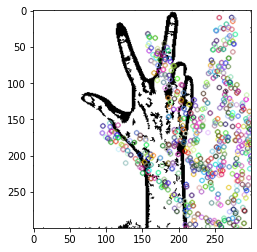

In [279]:
filename = preprocess_files[2]

kp, des = get_keypoints(filename)
img = cv2.imread(filename)

plt.imshow(cv2.drawKeypoints(img, kp, None))
plt.show()